In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

from scipy.special import expit

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import loguniform, uniform

In [9]:
df_train=pd.read_csv("../../ravdess_features_train_pulito.csv")
df_test=pd.read_csv("../../ravdess_features_test_pulito.csv")

df_train["emotion"]=df_train["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_train["emotional_intensity"]=df_train["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_train["sex"]=df_train["sex"].replace(["M", "F"],[0,1])
df_train["statement"]=df_train["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_train["vocal_channel"]=df_train["vocal_channel"].replace(["speech", "song"],[0,1])

df_test["emotion"]=df_test["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_test["emotional_intensity"]=df_test["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_test["sex"]=df_test["sex"].replace(["M", "F"],[0,1])
df_test["statement"]=df_test["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_test["vocal_channel"]=df_test["vocal_channel"].replace(["speech", "song"],[0,1])

### Outlier dropping

In [10]:
df_train.drop(axis="index", labels=[35,243,451,554,563,658,659,1031,1075,1283], inplace=True)
X_train=df_train.drop(columns=["emotion"]).values
y_train=df_train.emotion.values

df_test.drop(axis="index", labels=[33,34,138,196,197,198,199], inplace=True)
X_test=df_test.drop(columns=["emotion"]).values
y_test=df_test.emotion.values

### Feature selection (da implementare)

In [11]:
sel = SelectKBest(k=108)
X_train = sel.fit_transform(X_train, y_train)
X_test = sel.transform(X_test)

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [108] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


### Scaling

In [13]:
scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

In [7]:
clf = LinearSVC(C=1.0, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.44408427876823336
F1-score [0.39189189 0.53080569 0.36538462 0.51282051 0.46753247 0.51886792
 0.29530201 0.46428571]
              precision    recall  f1-score   support

           0       0.56      0.30      0.39        96
           1       0.46      0.63      0.53        89
           2       0.34      0.40      0.37        96
           3       0.43      0.62      0.51        48
           4       0.62      0.38      0.47        48
           5       0.47      0.57      0.52        96
           6       0.42      0.23      0.30        96
           7       0.41      0.54      0.46        48

    accuracy                           0.44       617
   macro avg       0.46      0.46      0.44       617
weighted avg       0.46      0.44      0.43       617



/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [8]:
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score, figsize=(10,10), title_fontsize=15, text_fontsize=15)
#plt.legend(["AUC of class fearful = 0.76", "AUC of class angry = 0.92", "AUC of class happy = 0.78", "AUC of class surprised = 0.89", "AUC of class neutral = 0.92", "AUC of class calm = 0.90", "AUC of class sad = 0.74", "AUC of class disgust = 0.89", "micro-avg AUC = 0.85", "macro-avg AUC = 0.85"], fontsize=15)
plt.title("")
plt.show()

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

# LinearSVC

### Tuning hyperparameter

In [25]:
def get_models_unweighted():
    models = dict()
    for p in [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1, 0.5, 1]:
        models[p] = LinearSVC(multi_class='ovr', C=p, class_weight=None)
    return models

def get_models_weighted():
    models = dict()
    for p in [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1, 0.5, 1]:
        models[p] = LinearSVC(multi_class='ovr', C=p, class_weight="balanced")
    return models

def evaluate_model_accuracy(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

def evaluate_model_f1(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    return scores

In [26]:
models = get_models_unweighted()
accuracy, f1, names = list(), list(), list()
for name, model in models.items():
	accuracy_scores = evaluate_model_accuracy(model, X_train, y_train)
	f1_scores = evaluate_model_f1(model, X_train, y_train)
	accuracy.append(accuracy_scores)
	f1.append(f1_scores)
	names.append(name)
	print(name)
	print('Accuracy:\t %.3f (%.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
	print('f1:\t %.3f (%.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
# Tempo stimato 4.30m

1e-05
Accuracy:	 0.334 (0.020)
f1:	 0.227 (0.021)
5e-05
Accuracy:	 0.378 (0.029)
f1:	 0.305 (0.031)
0.0001
Accuracy:	 0.396 (0.026)
f1:	 0.339 (0.027)
0.0005
Accuracy:	 0.450 (0.027)
f1:	 0.414 (0.027)
0.001
Accuracy:	 0.465 (0.028)
f1:	 0.431 (0.027)
0.005
Accuracy:	 0.496 (0.028)
f1:	 0.470 (0.028)
0.01
Accuracy:	 0.510 (0.032)
f1:	 0.488 (0.032)
0.05
Accuracy:	 0.530 (0.034)
f1:	 0.517 (0.033)
0.1
Accuracy:	 0.534 (0.035)
f1:	 0.521 (0.035)
0.5
Accuracy:	 0.544 (0.041)
f1:	 0.534 (0.041)
1
Accuracy:	 0.545 (0.035)
f1:	 0.539 (0.036)


In [27]:

models = get_models_weighted()
accuracy, f1, names = list(), list(), list()
for name, model in models.items():
	accuracy_scores = evaluate_model_accuracy(model, X_train, y_train)
	f1_scores = evaluate_model_f1(model, X_train, y_train)
	accuracy.append(accuracy_scores)
	f1.append(f1_scores)
	names.append(name)
	print(name)
	print('Accuracy:\t %.3f (%.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
	print('f1:\t %.3f (%.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
	print("\n")

# Tempo stimato 4.30m

1e-05
Accuracy:	 0.336 (0.024)
f1:	 0.227 (0.022)


5e-05
Accuracy:	 0.369 (0.026)
f1:	 0.290 (0.027)


0.0001
Accuracy:	 0.389 (0.024)
f1:	 0.328 (0.026)


0.0005
Accuracy:	 0.448 (0.027)
f1:	 0.412 (0.027)


0.001
Accuracy:	 0.472 (0.031)
f1:	 0.442 (0.030)


0.005
Accuracy:	 0.501 (0.033)
f1:	 0.479 (0.032)


0.01
Accuracy:	 0.510 (0.032)
f1:	 0.491 (0.031)


0.05
Accuracy:	 0.524 (0.035)
f1:	 0.509 (0.036)


0.1
Accuracy:	 0.528 (0.038)
f1:	 0.514 (0.040)


0.5
Accuracy:	 0.538 (0.044)
f1:	 0.528 (0.044)


1
Accuracy:	 0.543 (0.042)
f1:	 0.534 (0.043)




Migliore risultato dataset completo (solo OD) C=0.05, class_weight="balanced"

Migliore risultato dataset con FS C=1, class_weight=None

In [23]:
clf = LinearSVC(C=1, class_weight=None, max_iter=10000, probability = True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

TypeError: __init__() got an unexpected keyword argument 'probability'

In [15]:
from scikitplot.metrics import plot_roc

In [ ]:
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score, figsize=(10,10), title_fontsize=15, text_fontsize=15)
#plt.legend(["AUC of class fearful = 0.76", "AUC of class angry = 0.92", "AUC of class happy = 0.78", "AUC of class surprised = 0.89", "AUC of class neutral = 0.92", "AUC of class calm = 0.90", "AUC of class sad = 0.74", "AUC of class disgust = 0.89", "micro-avg AUC = 0.85", "macro-avg AUC = 0.85"], fontsize=15)
plt.title("")
plt.show()

## Nonlinear SVM

In [31]:

param_grid = {
    "C": [1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "coef0": [1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
    "gamma": ["scale", "auto"],
    "class_weight": ["balanced", None]
}
grid = RandomizedSearchCV(
    SVC(max_iter=-1),
    param_distributions=param_grid,
    scoring="accuracy",
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter=500,
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_

# tempo impiegato circa 34 minuti

In [32]:
grid.best_params_

{'kernel': 'poly',
 'gamma': 'auto',
 'coef0': 0.95,
 'class_weight': None,
 'C': 1}

Best params dataset completo (no outliers): C=0.75, class_weight='balanced', coef0=1, gamma='auto', kernel='poly'.

Best params dataset con FS: {'kernel': 'poly', 'gamma': 'auto', 'coef0': 0.95, 'C': 1}

In [33]:
clf = SVC(C=1, class_weight='balanced', coef0=0.95, gamma='auto', kernel='poly', degree=2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.45705024311183146
F1-score [0.28346457 0.5698324  0.42424242 0.51162791 0.48235294 0.57627119
 0.16666667 0.53731343]
              precision    recall  f1-score   support

           0       0.58      0.19      0.28        96
           1       0.57      0.57      0.57        89
           2       0.41      0.44      0.42        96
           3       0.41      0.69      0.51        48
           4       0.34      0.85      0.48        48
           5       0.63      0.53      0.58        96
           6       0.42      0.10      0.17        96
           7       0.42      0.75      0.54        48

    accuracy                           0.46       617
   macro avg       0.47      0.52      0.44       617
weighted avg       0.49      0.46      0.43       617



Non convince il coef0. Faccio GridSearchCV su quest'ultimo.

In [ ]:
clf = SVC(C=0.75, class_weight='balanced', coef0=1, gamma='auto', kernel='poly', degree=2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5283630470016207
F1-score [0.41610738 0.68656716 0.47236181 0.47706422 0.60294118 0.58241758
 0.35460993 0.58119658]
              precision    recall  f1-score   support

           0       0.58      0.32      0.42        96
           1       0.62      0.78      0.69        89
           2       0.46      0.49      0.47        96
           3       0.43      0.54      0.48        48
           4       0.47      0.85      0.60        48
           5       0.62      0.55      0.58        96
           6       0.56      0.26      0.35        96
           7       0.49      0.71      0.58        48

    accuracy                           0.53       617
   macro avg       0.53      0.56      0.52       617
weighted avg       0.54      0.53      0.51       617



In [39]:
clf = SVC(C=0.75, class_weight='balanced', coef0=1, gamma='auto', kernel='poly', degree=3)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.44570502431118314
F1-score [0.3125     0.53932584 0.42364532 0.50393701 0.43209877 0.58100559
 0.17886179 0.50746269]
              precision    recall  f1-score   support

           0       0.62      0.21      0.31        96
           1       0.54      0.54      0.54        89
           2       0.40      0.45      0.42        96
           3       0.41      0.67      0.50        48
           4       0.31      0.73      0.43        48
           5       0.63      0.54      0.58        96
           6       0.41      0.11      0.18        96
           7       0.40      0.71      0.51        48

    accuracy                           0.45       617
   macro avg       0.46      0.49      0.43       617
weighted avg       0.48      0.45      0.42       617



### GridSearchCV su coef0 e C

In [ ]:
'''
param_grid = {
    "coef0": np.linspace(0,2,num=50),
    "C": np.linspace(1e-16,1,num=25),
}
grid = GridSearchCV(
    SVC(gamma="auto", kernel="poly", class_weight="balanced", max_iter=-1),
    param_grid=param_grid,
    scoring="accuracy",
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_
'''
# tempo stimato circa 220 minuti

In [ ]:
grid.best_params_

{'C': 1.0, 'coef0': 1.9591836734693877}

coef0=2 risulta il migliore

In [ ]:
clf = SVC(C=1, class_weight='balanced', coef0=2, gamma='auto', kernel='poly', degree=2, max_iter=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5072933549432739
F1-score [0.44871795 0.60273973 0.44680851 0.5        0.57142857 0.58695652
 0.36619718 0.48076923]
              precision    recall  f1-score   support

           0       0.58      0.36      0.45        96
           1       0.51      0.74      0.60        89
           2       0.46      0.44      0.45        96
           3       0.45      0.56      0.50        48
           4       0.45      0.79      0.57        48
           5       0.61      0.56      0.59        96
           6       0.57      0.27      0.37        96
           7       0.45      0.52      0.48        48

    accuracy                           0.51       617
   macro avg       0.51      0.53      0.50       617
weighted avg       0.52      0.51      0.50       617



In [ ]:
clf = SVC(C=0.5, class_weight='balanced', coef0=2, gamma='auto', kernel='poly', degree=2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.520259319286872
F1-score [0.42384106 0.66666667 0.46560847 0.48214286 0.60294118 0.56830601
 0.32857143 0.56896552]
              precision    recall  f1-score   support

           0       0.58      0.33      0.42        96
           1       0.58      0.78      0.67        89
           2       0.47      0.46      0.47        96
           3       0.42      0.56      0.48        48
           4       0.47      0.85      0.60        48
           5       0.60      0.54      0.57        96
           6       0.52      0.24      0.33        96
           7       0.49      0.69      0.57        48

    accuracy                           0.52       617
   macro avg       0.52      0.56      0.51       617
weighted avg       0.53      0.52      0.50       617



In [14]:
clf = SVC(C=0.05, class_weight='balanced', coef0=1, gamma='auto', kernel='poly', degree=2, probability = True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.4343598055105348
F1-score [0.24793388 0.61744966 0.4744186  0.52112676 0.43243243 0.45121951
 0.11111111 0.48      ]
              precision    recall  f1-score   support

           0       0.60      0.16      0.25        96
           1       0.77      0.52      0.62        89
           2       0.43      0.53      0.47        96
           3       0.39      0.77      0.52        48
           4       0.29      0.83      0.43        48
           5       0.54      0.39      0.45        96
           6       0.50      0.06      0.11        96
           7       0.35      0.75      0.48        48

    accuracy                           0.43       617
   macro avg       0.48      0.50      0.42       617
weighted avg       0.51      0.43      0.40       617



In [15]:
from scikitplot.metrics import plot_roc


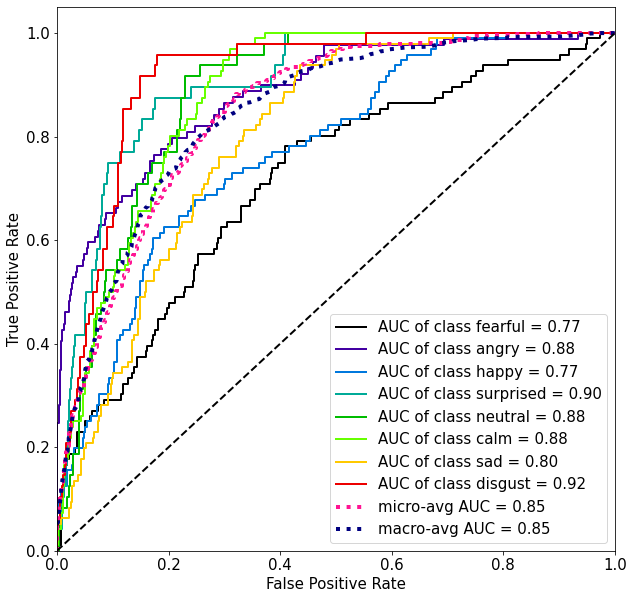

In [17]:
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.legend(["AUC of class fearful = 0.77", "AUC of class angry = 0.88", "AUC of class happy = 0.77", "AUC of class surprised = 0.90", "AUC of class neutral = 0.88", "AUC of class calm = 0.88", "AUC of class sad = 0.80", "AUC of class disgust = 0.92", "micro-avg AUC = 0.85", "macro-avg AUC = 0.85"], fontsize=15)
plt.title("")
plt.show()